# Categorisez automatiquement des questions - Modelisation

In [1]:
%%script echo skipping
from google.colab import drive
drive.mount('/content/drive')

skipping


# SOMMAIRE
* [PREPARATION](#PREPARATION)
* [CHARGEMENT](#CHARGEMENT)
* [MODELISATION](#Modelisation)
    * [Bayes naïf](#Bayes-naïf)
    * [Random forest](#Random-forest)
    * [XGBoost](#XGBoost)
    * [Reseau de neurones](#Reseau-de-neurones)
    * [LDA](#LDA)

# PREPARATION

## import des librairies

In [2]:
import joblib
import pandas as pd
import matplotlib as mplt
import matplotlib.pyplot as plt
from matplotlib import cm #colormap
import numpy as np

import seaborn as sns
import re

from sklearn.decomposition import LatentDirichletAllocation

from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn import linear_model

from xgboost import XGBClassifier

import tensorflow as tf

## Paramétrage du notebook

In [3]:
from matplotlib import font_manager

font_dirs = ['/Library/Fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Comic Sans'
plt.rcParams['font.sans-serif'] = 'Franklin Gothic Book'

In [4]:
sns.set(rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

#mplt.font_manager._rebuild()
#mplt.font_manager.findfont('Franklin Gothic Book',rebuild_if_missing=True)


pd.options.display.max_colwidth=200
pd.options.display.min_rows=30
pd.options.display.max_columns=50

## Declaration des fonctions

In [5]:
def confusionMatrixAcc(y_true, y_pred):
    """
    Fonction qui retourne la matrice de confusion

    Parameters
    ----------
    y_true : pandas Series
        une Serie de valeurs (labels) reelles
    y_pred : pandas Series
        une Serie de valeurs (labels) predites
    Returns
    -------
    confusionMatrix : DataFrame
        la matrice de confusion
    """

    dfConfusion=pd.crosstab(y_test, y_pred_test,rownames=['Reel'], colnames=['Predit'], margins=False)
    confusionMatrix=pd.DataFrame()

    for c in dfConfusion.columns:
        TP=dfConfusion.loc[c,c]
        FP=dfConfusion.loc[:,c].sum()-dfConfusion.loc[c,c]
        TN=np.diagonal(dfConfusion).sum()-dfConfusion.loc[c,c]
        FN=dfConfusion.loc[c,:].sum()-dfConfusion.loc[c,c]
        TPR=TP/(TP+FN) # taux de vrai positif
        FPR=FP/(FP+TN) # taux de faux positifs
        Accuracy=(TP+TN)/(TP+FP+TN+FN)
        confusionMatrix=pd.concat([confusionMatrix,
        pd.DataFrame({
            'Class':c,
            'TP':[TP],
            'FP':[FP],
            'TN':[TN],
            'FN':[FN],
            'TPR':[TPR],
            'FPR':[FPR],
            'Accuracy':[Accuracy]})
            ])
    
    confusionMatrix.reset_index(drop=True,inplace=True)
    confusionMatrix=confusionMatrix.sort_values('Accuracy',ascending=False)
    return confusionMatrix

def getClass(row):
    # no de colonne ayant le TFIDF max
    if row.max()==0: # TF IDF nul pour toute la ligne
        return 0
    else:
        tags=row.idxmax().split() #separation du bigramme
        #print(tags)
        rowclass=tagclass.get(tags[0],0)
        if rowclass==0:
            #print('row null')
            rowclass=tagclass.get(tags[1],0)
        return rowclass

# CHARGEMENT

In [6]:
dfCleaned=joblib.load('dfCleaned5000.jbl.bz2')
dfTFIDFCommon=joblib.load('dfTFIDFCommon.jbl.bz2')
dfTFIDFCommonTarget=joblib.load('dfTFIDFCommonTarget.jbl.bz2')
tagclass=joblib.load('tagclass.jbl.bz2')
#dfTFIDF_bodies_titles=joblib.load('dfTFIDF_bodies_titles.jbl.bz2')
#dfTFIDF_bodies_titlesTarget=joblib.load('dfTFIDF_bodies_titlesTarget.jbl.bz2')

In [7]:
dfTFIDFCommon.head(8)

,source class,two different,div content,property found,remote vm,memory time,multiple core,name unsatisfied,problem parse,ljava lang,use class,fail error,loop group,get difference,connection server,java web,firefox safari,another html,console component,highchart api,increase roll,define conversion,executequery string,android webview,proc iml,...,url jsp,last flag,hour period,define python,integer struct,php build,payment decline,width set,passing object,parse xml,exception org,file list,get width,width property,text top,control tree,revision number,matcher return,fix size,sitecore client,file need,err enoent,method support,use python,azure iot
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.398647,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
dfTFIDFCommonTarget.head(8)

,problem sql,connect mysql,html form,php multidimensional,div content,convert one,get server,value contains,component equal,search android,one change,click javascript,ljava lang,content source,java web,html twig,connection server,profile function,show second,app icon,php api,content use,another html,console component,someone age,...,constant storage,define python,arithmetic operation,php build,ajax php,library ruby,sql query,parse xml,content type,exception org,tzinfo timezone,performance comparison,config file,use java,instance ironpython,java code,work sql,first one,control tree,nest json,revision number,nest exception,visual web,use python,net remoting
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.021777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelisation

In [9]:
tagclass

{'javascript': 1,
 'android': 2,
 'php': 3,
 'java': 4,
 'net': 5,
 'jquery': 6,
 'python': 7,
 'sql': 8,
 'html': 9,
 'mysql': 10,
 'asp': 11,
 'iphone': 12,
 'css': 13,
 'wpf': 14,
 'objective': 15,
 'arrays': 16,
 'server': 17,
 'ruby': 18,
 'json': 19,
 'js': 20,
 'studio': 21,
 'visual': 22,
 'spring': 23,
 'xml': 24,
 'ios': 25,
 'windows': 26,
 'rails': 27,
 'mvc': 28,
 'on': 29,
 'wordpress': 30}

In [10]:
X=dfTFIDFCommon.values

In [11]:
y=dfTFIDFCommonTarget.apply(lambda row:getClass(row),axis=1)

In [12]:
X.shape,y.shape

((2000, 2964), (2000,))

In [13]:
# index ayant une classe <> 0
i=y[y>0].index
len(i)

520

In [14]:
y=y.iloc[i]
X=(dfTFIDFCommonTarget.iloc[i]).values

<AxesSubplot:>

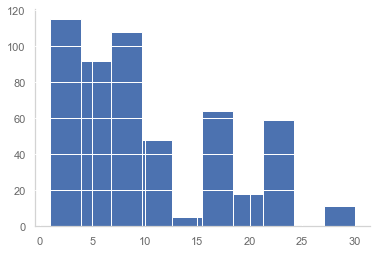

In [15]:
y.hist()

In [16]:
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 17, 18, 19,
       21, 22, 23, 24, 28, 30])

In [17]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state = 49)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((364, 764), (156, 764), (364,), (156,))

In [18]:
np.unique(y_test)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 17, 19, 21, 22,
       24, 28, 30])

## Bayes naïf

In [19]:
NaiveBayes = naive_bayes.GaussianNB().fit(X_train, y_train)
y_pred_train=NaiveBayes.predict(X_train)
y_pred_test=NaiveBayes.predict(X_test)
y_pred_train.shape,y_pred_test.shape

((364,), (156,))

In [20]:
np.unique(y_pred_train)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 17, 18, 19,
       21, 22, 23, 24, 28, 30])

(array([33., 32., 21., 14.,  0., 21.,  7., 21.,  0.,  7.]),
 array([ 1. ,  3.9,  6.8,  9.7, 12.6, 15.5, 18.4, 21.3, 24.2, 27.1, 30. ]),
 <BarContainer object of 10 artists>)

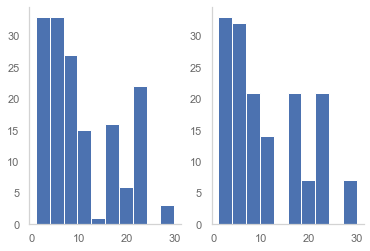

In [21]:
plt.subplot(1,2,1)
plt.hist(y_test)

plt.subplot(1,2,2)
plt.hist(y_pred_test)

In [22]:
# scores exactitude, ari
accuracy = accuracy_score(y_test, y_pred_test) 
ari = adjusted_rand_score(y_test, y_pred_test)
accuracy, ari

(0.7115384615384616, 0.49567681551273707)

In [23]:
np.unique(y_test), np.unique(y_pred_test)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 17, 19, 21, 22,
        24, 28, 30]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 17, 18, 19, 22, 24,
        28, 30]))

## Random forest

In [24]:
rfc = RandomForestClassifier(random_state=43)

rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=43)

In [25]:
y_pred_train=rfc.predict(X_train)
y_pred_test=rfc.predict(X_test)
np.unique(y_pred_train)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 17, 18, 19,
       21, 22, 23, 24, 28, 30])

(array([50., 25., 21., 18.,  0., 14.,  7., 19.,  0.,  2.]),
 array([ 1. ,  3.9,  6.8,  9.7, 12.6, 15.5, 18.4, 21.3, 24.2, 27.1, 30. ]),
 <BarContainer object of 10 artists>)

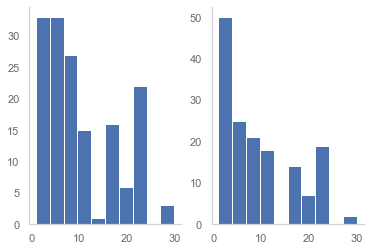

In [26]:
plt.subplot(1,2,1)
plt.hist(y_test)

plt.subplot(1,2,2)
plt.hist(y_pred_test)

In [27]:
# scores exactitude, ari
accuracy = accuracy_score(y_test, y_pred_test) 
ari = adjusted_rand_score(y_test, y_pred_test)
accuracy, ari

(0.6923076923076923, 0.4385569493553976)

In [28]:
y_test.shape,y_pred_test.shape

((156,), (156,))

In [29]:
np.unique(y_test), np.unique(y_pred_test)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 17, 19, 21, 22,
        24, 28, 30]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 17, 19, 22, 24, 30]))

In [30]:
dfConfusion=confusionMatrixAcc(y_test, y_pred_test)
dfConfusion.sort_values(by='Class')

,Class,TP,FP,TN,FN,TPR,FPR,Accuracy
0,1,4,26,70,0,1.000000,0.270833,0.740000
1,2,9,3,65,7,0.562500,0.044118,0.880952
2,3,6,2,68,7,0.461538,0.028571,0.891566
3,4,14,1,60,3,0.823529,0.016393,0.948718
4,5,2,0,72,6,0.250000,0.000000,0.925000
5,6,6,2,68,2,0.750000,0.028571,0.948718
6,7,8,1,66,1,0.888889,0.014925,0.973684
7,8,8,1,66,1,0.888889,0.014925,0.973684
8,9,3,0,71,6,0.333333,0.000000,0.925000
9,10,2,0,72,0,1.000000,0.000000,1.000000


## Regression logistique

In [31]:
lr = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')

In [32]:
lr.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [33]:
y_pred_train=lr.predict(X_train)
y_pred_test=lr.predict(X_test)
np.unique(y_pred_train)

array([ 2,  3,  4,  8, 17])

(array([  3.,   3.,   0.,   0.,   2.,   0.,   0.,   0.,   0., 148.]),
 array([ 2. ,  3.5,  5. ,  6.5,  8. ,  9.5, 11. , 12.5, 14. , 15.5, 17. ]),
 <BarContainer object of 10 artists>)

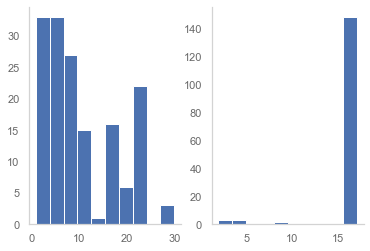

In [34]:
plt.subplot(1,2,1)
plt.hist(y_test)

plt.subplot(1,2,2)
plt.hist(y_pred_test)

In [35]:
# scores exactitude, ari
accuracy = accuracy_score(y_test, y_pred_test) 
ari = adjusted_rand_score(y_test, y_pred_test)
accuracy, ari

(0.14102564102564102, 0.0008917705654161883)

In [36]:
dfConfusion=confusionMatrixAcc(y_test, y_pred_test)
dfConfusion

,Class,TP,FP,TN,FN,TPR,FPR,Accuracy
3,8,2,0,6,7,0.222222,0.000000,0.533333
1,3,1,1,7,12,0.076923,0.125000,0.380952
2,4,3,0,5,14,0.176471,0.000000,0.363636
0,2,0,1,8,16,0.000000,0.111111,0.320000
4,17,16,132,-8,0,1.000000,1.064516,0.057143


## XGBoost

In [37]:
model=XGBClassifier(eta=0.1,n_estimators=100,max_depth=4,subsample=1,colsample_bytree=0.8,objective='multi:softmax')
model.fit(X_train,y_train)

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:33:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eta=0.1, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [38]:
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)
np.unique(y_pred_train)

array([ 1,  2,  3,  4,  5,  7,  8,  9, 11, 17, 22, 24])

In [39]:
# scores exactitude, ari
accuracy = accuracy_score(y_test, y_pred_test) 
ari = adjusted_rand_score(y_test, y_pred_test)
accuracy, ari

(0.41025641025641024, 0.09617175722382056)

In [40]:
dfConfusion=confusionMatrixAcc(y_test, y_pred_test)
dfConfusion.sort_values(by='Class')

/var/folders/c7/w4lf4cp91_j_p3dxm9w00rmh0000gn/T/ipykernel_4430/3502535292.py:26: RuntimeWarning: divide by zero encountered in long_scalars
  FPR=FP/(FP+TN) # taux de faux positifs


,Class,TP,FP,TN,FN,TPR,FPR,Accuracy
0,2,7,4,1,9,0.437500,0.800000,0.380952
1,3,4,6,4,9,0.307692,0.600000,0.347826
2,4,10,2,-2,7,0.588235,inf,0.470588
3,5,2,3,6,6,0.250000,0.333333,0.470588
4,7,1,0,7,8,0.111111,0.000000,0.500000
5,8,8,1,0,1,0.888889,1.000000,0.800000
6,9,7,70,1,2,0.777778,0.985915,0.100000
7,11,9,3,-1,0,1.000000,1.500000,0.727273
8,17,3,2,5,13,0.187500,0.285714,0.347826
9,22,6,0,2,2,0.750000,0.000000,0.800000


## Reseau de neurones

In [41]:
X.shape

(520, 764)

In [42]:
tf.config.run_functions_eagerly(True) #activation de l'execution en mode dynamique

# Parametres du reseau de neurones
EPOCHS = 200 # iterations
BATCH_SIZE = 8 #taille de l'echantillon par iteration
VERBOSE = 1
NB_CLASSES = 30   # nombre de neurones/classe en sortie
N_HIDDEN = 18 # nombre de neurones des couches cachees = nombre d'observations/(2*(nombre de neurones input + nombre de neurones output))
VALIDATION_SPLIT = 0.2 # pourcentage des donnees d'entrainement reservées pour la validation
DROPOUT = 0.3

INPUT_SHAPE = X_train.shape

In [43]:
INPUT_SHAPE[1]

764

In [44]:
# Creation du modele
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(INPUT_SHAPE[1],
    input_shape=INPUT_SHAPE,
    name='input_layer', 
    activation='relu'))
model.add(tf.keras.layers.Dropout(DROPOUT))
model.add(tf.keras.layers.Dense(N_HIDDEN,
    name='hidden_layer_1',
    activation='relu'))
model.add(tf.keras.layers.Dropout(DROPOUT))
model.add(tf.keras.layers.Dense(N_HIDDEN,
    name='hidden_layer_2',
    activation='relu'))
model.add(tf.keras.layers.Dropout(DROPOUT))
model.add(tf.keras.layers.Dense(NB_CLASSES+1,
    name='output_layer',
    activation='softmax'))

2021-11-20 23:33:18.018022: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [45]:
# Caracteristique/description du modele
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 364, 764)          584460    
_________________________________________________________________
dropout (Dropout)            (None, 364, 764)          0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 364, 18)           13770     
_________________________________________________________________
dropout_1 (Dropout)          (None, 364, 18)           0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 364, 18)           342       
_________________________________________________________________
dropout_2 (Dropout)          (None, 364, 18)           0         
_________________________________________________________________
output_layer (Dense)         (None, 364, 31)           5

In [46]:
# Compilation
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # methode de calcul de cout
              metrics=['accuracy']) # methode d'evaluation

In [47]:
%%time
callbacks = [
  #  Objet History pour monitorer les iterations
  tf.keras.callbacks.History(),
  # Logs pour TensorBoard dans le repertoire './logs' 
  #tf.keras.callbacks.TensorBoard(log_dir='./logs') # activation des logs pour TensorBoard
]

history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS , verbose = VERBOSE, validation_split = VALIDATION_SPLIT, callbacks = callbacks)

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
2021-11-20 23:33:18.166020: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/200
52/52 [==============================] - 1s 28ms/step - loss: 3.4267 - accuracy: 0.0798 - val_loss: 3.4025 - val_accuracy: 0.0577
Epoch 2/200
52/52 [==============================] - 1s 13ms/step - loss: 3.3786 - accuracy: 0.1156 - val_loss: 3.3247 - val_accuracy: 0.0577
Epoch 3/200
52/52 [==============================] - 1s 14ms/step - loss: 3.2054 - accuracy: 0.1265 - val_loss: 3.1592 - val_accuracy: 0.0577
Epoch 4/200
52/52 [==============================] - 1s 17ms/step - loss: 3.0425 - accuracy: 0.1136 - val_loss: 3.0620 - val_accuracy: 0.0577
Epoch 5/200
52/52 [==============================] - 1s 15ms/step - loss: 2.9470 - accuracy: 0.1121 - val_loss: 2.9757 - val_accuracy: 0.0577
Epoch 6/200
52/52 [==============================] - 1s 16ms/step - loss: 2.7919 - accuracy: 0.1308 - val_loss: 2.9186 - val_accuracy: 0.1442
Epoch 7/200
52/52 [==============================] - 1s 16ms/step - loss: 2.6874 - accuracy: 0.1494 - val_loss: 2.8407 - val_accuracy: 0.1538
Epoch 

52/52 [==============================] - 1s 13ms/step - loss: 1.1711 - accuracy: 0.6126 - val_loss: 2.2306 - val_accuracy: 0.5577
Epoch 59/200
52/52 [==============================] - 1s 13ms/step - loss: 0.9881 - accuracy: 0.6786 - val_loss: 2.1716 - val_accuracy: 0.5865
Epoch 60/200
52/52 [==============================] - 1s 13ms/step - loss: 1.0177 - accuracy: 0.6850 - val_loss: 2.2070 - val_accuracy: 0.5769
Epoch 61/200
52/52 [==============================] - 1s 13ms/step - loss: 1.0089 - accuracy: 0.6854 - val_loss: 2.2236 - val_accuracy: 0.5769
Epoch 62/200
52/52 [==============================] - 1s 13ms/step - loss: 0.9450 - accuracy: 0.7073 - val_loss: 2.2623 - val_accuracy: 0.5385
Epoch 63/200
52/52 [==============================] - 1s 13ms/step - loss: 0.9477 - accuracy: 0.6776 - val_loss: 2.1635 - val_accuracy: 0.6058
Epoch 64/200
52/52 [==============================] - 1s 17ms/step - loss: 0.9357 - accuracy: 0.6990 - val_loss: 2.2376 - val_accuracy: 0.5865
Epoch 65/200

52/52 [==============================] - 1s 14ms/step - loss: 0.6099 - accuracy: 0.7857 - val_loss: 3.3237 - val_accuracy: 0.6058
Epoch 116/200
52/52 [==============================] - 1s 15ms/step - loss: 0.7088 - accuracy: 0.7640 - val_loss: 3.1512 - val_accuracy: 0.6346
Epoch 117/200
52/52 [==============================] - 1s 14ms/step - loss: 0.6352 - accuracy: 0.7841 - val_loss: 3.3783 - val_accuracy: 0.6250
Epoch 118/200
52/52 [==============================] - 1s 15ms/step - loss: 0.7458 - accuracy: 0.7280 - val_loss: 3.2601 - val_accuracy: 0.6250
Epoch 119/200
52/52 [==============================] - 1s 14ms/step - loss: 0.7006 - accuracy: 0.7499 - val_loss: 3.3613 - val_accuracy: 0.5962
Epoch 120/200
52/52 [==============================] - 1s 15ms/step - loss: 0.5935 - accuracy: 0.7650 - val_loss: 3.1277 - val_accuracy: 0.6538
Epoch 121/200
52/52 [==============================] - 1s 14ms/step - loss: 0.5494 - accuracy: 0.8000 - val_loss: 3.2313 - val_accuracy: 0.6442
Epoch 

Epoch 172/200
52/52 [==============================] - 1s 15ms/step - loss: 0.5458 - accuracy: 0.8152 - val_loss: 4.5493 - val_accuracy: 0.6635
Epoch 173/200
52/52 [==============================] - 1s 13ms/step - loss: 0.4847 - accuracy: 0.8350 - val_loss: 4.5731 - val_accuracy: 0.6442
Epoch 174/200
52/52 [==============================] - 1s 14ms/step - loss: 0.5335 - accuracy: 0.7927 - val_loss: 4.4794 - val_accuracy: 0.6442
Epoch 175/200
52/52 [==============================] - 1s 14ms/step - loss: 0.4411 - accuracy: 0.8545 - val_loss: 4.4299 - val_accuracy: 0.6635
Epoch 176/200
52/52 [==============================] - 1s 14ms/step - loss: 0.4524 - accuracy: 0.8417 - val_loss: 4.5672 - val_accuracy: 0.6442
Epoch 177/200
52/52 [==============================] - 1s 14ms/step - loss: 0.5891 - accuracy: 0.7821 - val_loss: 4.5219 - val_accuracy: 0.6442
Epoch 178/200
52/52 [==============================] - 1s 15ms/step - loss: 0.5309 - accuracy: 0.8073 - val_loss: 4.7941 - val_accuracy:

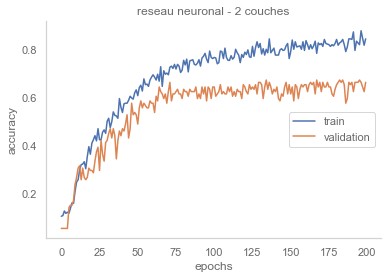

In [48]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('reseau neuronal - 2 couches')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train' , 'validation'] , loc = 'right')
plt.show()

In [49]:
y_pred_test=np.squeeze(model.predict_classes(X_test)) #helps to get rid of useless one dimension arrays  and predict classes directly instead of probability

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [50]:
np.unique(y_pred_test),len(y_pred_test)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 17, 19, 21, 22,
        24, 30]),
 156)

(array([35., 32., 28., 15.,  1., 15.,  5., 23.,  0.,  2.]),
 array([ 1. ,  3.9,  6.8,  9.7, 12.6, 15.5, 18.4, 21.3, 24.2, 27.1, 30. ]),
 <BarContainer object of 10 artists>)

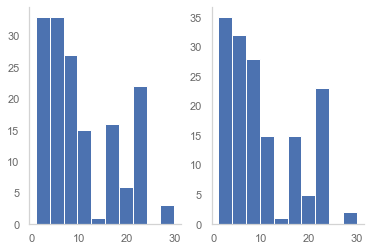

In [51]:
plt.subplot(1,2,1)
plt.hist(y_test)

plt.subplot(1,2,2)
plt.hist(y_pred_test)

In [52]:
# scores exactitude, ari
accuracy = accuracy_score(y_test, y_pred_test) 
ari = adjusted_rand_score(y_test, y_pred_test)
accuracy, ari

(0.9358974358974359, 0.8934332189013726)

In [53]:
dfConfusion=confusionMatrixAcc(y_test, y_pred_test)
dfConfusion

,Class,TP,FP,TN,FN,TPR,FPR,Accuracy
9,10,2,0,142,0,1.000000,0.000000,1.000000
6,7,9,0,135,0,1.000000,0.000000,1.000000
16,22,8,0,136,0,1.000000,0.000000,1.000000
15,21,1,0,143,0,1.000000,0.000000,1.000000
12,14,1,0,143,0,1.000000,0.000000,1.000000
1,2,16,0,128,0,1.000000,0.000000,1.000000
18,30,2,0,142,0,1.000000,0.000000,1.000000
4,5,8,0,136,0,1.000000,0.000000,1.000000
3,4,17,0,127,0,1.000000,0.000000,1.000000
5,6,7,0,137,1,0.875000,0.000000,0.993103


## LDA

In [54]:
# instanciation du modele
model=LatentDirichletAllocation(n_components=20)

lda_matrix = model.fit_transform(X_train)

# recuperation des composantes
lda_components=model.components_

# termes des thematiques
terms = dfTFIDFCommon.columns

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['image html', 'error could', 'get ui', 'string value', 'gzip javascript', 'host prebid', 'execution order']
Topic 1:  ['connection server', 'form element', 'html twig', 'get value', 'get full', 'xaml code', 'break point']
Topic 2:  ['receive memory', 'vrfy etrn', 'apply node', 'auto fit', 'nunjucks template', 'request length', 'word document']
Topic 3:  ['run remove', 'setpos method', 'method contain', 'vm reboot', 'select multiple', 'button popup', 'connect server']
Topic 4:  ['hyper run', 'path live', 'source class', 'arraylist object', 'populate drop', 'custom mojo', 'item list']
Topic 5:  ['wsdl soap', 'script language', 'system xaml', 'cs file', 'fix error', 'use wif', 'error process']
Topic 6:  ['rename file', 'android textview', 'fix error', 'pdf use', 'run docker', 'xml clob', 'id row']
Topic 7:  ['div contains', 'save image', 'static folder', 'image detect', 'window phone', 'green mode', 'single view']
Topic 8:  ['value ini', 'project dialog', 'request trap', 'get u